In [1]:
%matplotlib inline

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import h5py
import numpy.ma as ma
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.interpolate import interp1d

In [3]:
#Opening h5 data file, reading data into arrays, then closing file
file_name = '20120123.004_lp_5min-cal.h5'
hf = h5py.File(file_name, 'r')

altitude = np.array(hf['NeFromPower/Altitude'])
Ne_NoTr = np.array(hf['NeFromPower/Ne_NoTr'])
dtime = np.array(hf['Time/dtime'])

hf.close()

#Printing shape of arrays
print 'Altiude Shape: ', altitude.shape
print 'Ne_NoTr Shape: ', Ne_NoTr.shape
print 'dtime Shape: ', dtime.shape

(4, 180)
(159, 4, 180)
(159, 2)


In [16]:
Ne_alt_0_p_0 = Ne_NoTr[:,0,0] # 1-D Ne array for altitude 0 and pole 0
Ne_alt_0_p_0_m1 = ma.masked_less_equal(Ne_alt_0_p_0,0) # masking negative electron densities
Ne_alt_0_p_0_m2 = np.ma.masked_invalid(Ne_alt_0_p_0_m1) # masking NaN values

#Adding 24 to  all values in time array after UT resets to zero
dtime_shift = np.copy(dtime)
dtime_shift[111,1] += 24
dtime_shift[112:,:]+= 24
#Creating mean time array
dtime_shift_mean = np.mean(dtime_shift,axis=1)
#Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
Ne_index = ma.nonzero(Ne_alt_0_p_0_m2)

time_mask_removed = np.copy(dtime_shift_mean)
# Setting masked values in time array to 0
for i in range(159):
    if np.isin(i,Ne_index) == False:
      time_mask_removed[i] = 0
    
# Removing zero values from time array   
time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
# Removing masked values from Ne array
Ne_interp = ma.compressed(Ne_alt_0_p_0_m2) 
# Defining interpolation function for Ne (as function of time)
interp_fun_Ne = interp1d(time_interp, Ne_interp,kind='cubic')

#Define time array w/ spacing similar to original time sampling
N = Ne_index[0]
n_time_elements = int(N[-1]) - int(N[0])+1
time_array = np.linspace(time_interp[0],time_interp[-1],n_time_elements)

#Define functions used to filter data
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
sampling_period_hr = time_array[1] - time_array[0]
fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

#Setting up (evenly spaced) time and Ne arrays
t = time_array
data = interp_fun_Ne(time_array)

#Filter data
filtered_data = butter_lowpass_filter(data, cutoff, fs, order)
filtfilt_data = filtfilt(b,a,data)

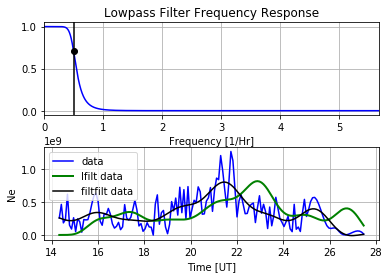

In [17]:
# Plot the frequency response.
w, h = freqz(b, a, 8000)

plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [1/Hr]')
plt.grid()

#Plot both the original and filtered signals.
plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, filtered_data, 'g-', linewidth=2, label='lfilt data')
plt.plot(t,filtfilt_data, 'k-', label='filtfilt data')
plt.plot()
plt.xlabel('Time [UT]')
plt.ylabel('Ne')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
#plt.savefig('B_Lowpass_Ne_vs_Time.png')